# Background removal with SVD

## Import necessary packages

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy import VideoFileClip # for reading video
# may need "from moviepy.editor import VideoFileClip" for earlier version of moviepy

## Adjust print() precisions
`suppress = True` means suppressing scientific notation.

In [2]:
np.set_printoptions(precision = 2, suppress = True)

## Useful matrix operations with numpy
- `A.T`: transpose of `A`
- `@`: matrix multiplication

## SVD

In [3]:
A = np.array([[-1,-3,-3,-1],
              [2.5,1.5,1.5,2.5],
              [-2,0,0,-2]])
A

array([[-1. , -3. , -3. , -1. ],
       [ 2.5,  1.5,  1.5,  2.5],
       [-2. ,  0. ,  0. , -2. ]])

Take the SVD of A. In Python, `np.linalg.svd` outputs U, S, and **V transpose**.

In [4]:
U, S, Vt = np.linalg.svd(A)

In [5]:
U

array([[ 0.67, -0.67,  0.33],
       [-0.67, -0.33,  0.67],
       [ 0.33,  0.67,  0.67]])

S stores the singular values of A, and `len(S)` is the smaller of the two dimensions of A.

In [6]:
S

array([6., 3., 0.])

In [7]:
V = Vt.T
V

array([[-0.5 , -0.5 ,  0.33, -0.63],
       [-0.5 ,  0.5 , -0.63, -0.33],
       [-0.5 ,  0.5 ,  0.63,  0.33],
       [-0.5 , -0.5 , -0.33,  0.63]])

### check that both U and V are orthogonal matrices

In [8]:
print(U.T@U)
print(V.T@V)

[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]
[[ 1. -0. -0.  0.]
 [-0.  1.  0. -0.]
 [-0.  0.  1. -0.]
 [ 0. -0. -0.  1.]]


### Check that $A = U\Sigma V^T$

In [9]:
Sigma = np.zeros([3,4])
Sigma[:3,:3] = np.diag(S)
Sigma

array([[6., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 0., 0.]])

In [10]:
np.abs(A - U@Sigma@V.T)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## Working with a video

### Read a video

In [11]:
video = VideoFileClip("../data/vid_background.avi")

In [12]:
video.fps, video.n_frames, video.w, video.h

(7.0, 794, 320, 240)

This video lasts $794/7\approx 113$ seconds.

In [13]:
# shorter video, the first 50 seconds
vid = video.subclipped(0, 50)

A video is a sequence of images.

In [25]:
#vid.preview()

### See the first frame of this video

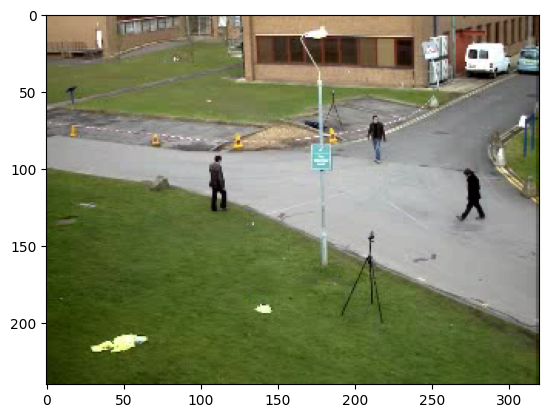

In [26]:
plt.imshow(vid.get_frame(0));

In [27]:
vid.get_frame(0).shape

(240, 320, 3)

This is a colored image.

Usually a colored image has 3 channels (RGB), making each frame a $240 \times 320 \times 3$ array.

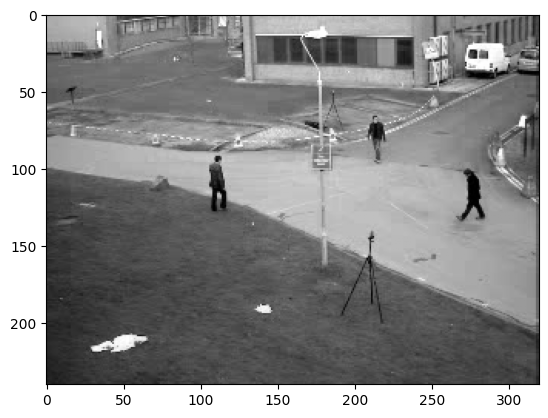

In [28]:
# showing the R channel
plt.imshow(video.get_frame(0)[:,:,0], cmap = 'gray');

### Color to grayscale
we can turn this colored image to a grayscale one by averaging all 3 channels

In [29]:
vid_0_gray = video.get_frame(0)[:,:,0]/3 + video.get_frame(0)[:,:,1]/3 + video.get_frame(0)[:,:,2]/3

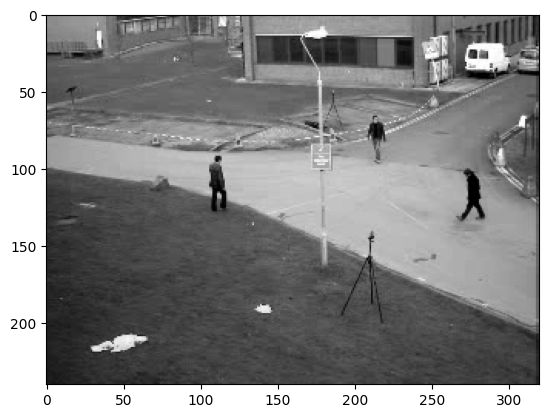

In [30]:
plt.imshow(vid_0_gray, cmap='gray');

In [31]:
vid_array = np.array(list(vid.iter_frames()))
vid_array.shape

(350, 240, 320, 3)

In [32]:
def rgb2gray(a):
    '''
    turn a colored video a into a gray scale video
    input a is 4d array: (n_frames, h, w, 3)
    output g is 3d array: (n_frames, h, w)
    '''
    return np.sum(a*np.ones(3).reshape([1,1,1,3])/3, axis = 3)

In [33]:
vid_gray_array = rgb2gray(vid_array)

In [34]:
vid_gray_array.shape

(350, 240, 320)

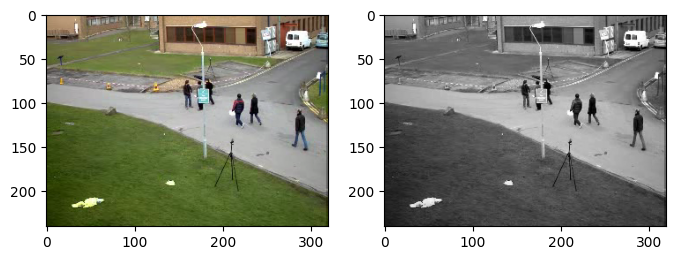

In [37]:
frame_idx = 50;
fig, axs1 = plt.subplots(1, 2, figsize=(8,8)) 
axs1[0].imshow(vid_array[frame_idx,...]);
axs1[1].imshow(vid_gray_array[frame_idx,...], cmap='gray');

## We will be working with `vid_gray_array` from here on

## Vectorization of a matrix
This is to turn any matrix into one column vector. Usually it will be vectorized along the columns, as indicated below

$\begin{bmatrix}a&b&c\\x&y&z\\d&e&f\end{bmatrix}\longrightarrow\begin{bmatrix}a\\x\\d\\b\\y\\e\\c\\z\\f\end{bmatrix}$

In [48]:
a = np.random.rand(2,3)
print('a:\n',a)
print('python default is to vectorize rowwise:\n', a.reshape([6,1]))
print('flatten() works to:\n', a.flatten())
print('use "order = \'F\'" for columnwise reshape\n',a.reshape([6,1], order = 'F'))

a:
 [[0.34 0.67 0.75]
 [0.2  0.94 0.14]]
python default is to vectorize rowwise:
 [[0.34]
 [0.67]
 [0.75]
 [0.2 ]
 [0.94]
 [0.14]]
flatten() works to:
 [0.34 0.67 0.75 0.2  0.94 0.14]
use "order = 'F'" for columnwise reshape
 [[0.34]
 [0.2 ]
 [0.67]
 [0.94]
 [0.75]
 [0.14]]


## Turn the video into ONE matrix
For each frame, vectorize it

`vid_gray_array` ($f \times m\times n$) $\longrightarrow$ `vid_gray_array_vec` ($f \times mn$)

In [49]:
m = vid_gray_array.shape[1]
n = vid_gray_array.shape[2]
vid_gray_array_vec = vid_gray_array.reshape([-1, m*n])

In [50]:
vid_gray_array_vec.shape

(350, 76800)

### sanity check

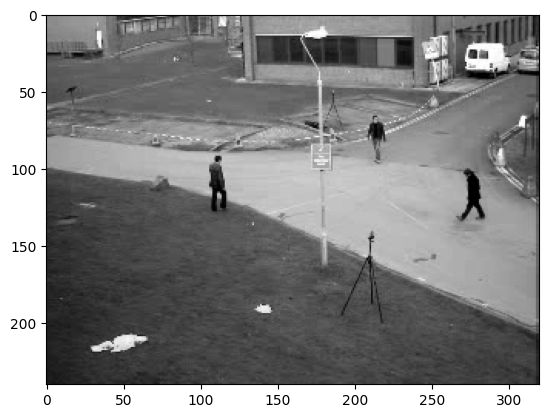

In [55]:
plt.imshow(vid_gray_array_vec[0,:].reshape([m,n]), cmap = 'gray');

In [58]:
U_v, S_v, Vt_v = np.linalg.svd(vid_gray_array_vec, full_matrices=False) 

In [60]:
print(U_v.shape)
print(Vt_v.shape)

(350, 350)
(350, 76800)


In [61]:
S_v

array([627573.74,  19847.2 ,  16831.31,  15639.76,  13616.08,  13415.44,
        13187.56,  12588.66,  12406.42,  11559.61,  11331.11,  11206.35,
        10450.16,  10331.89,  10232.44,  10074.59,   9760.55,   9624.05,
         9392.74,   9076.56,   8842.29,   8758.15,   8658.15,   8359.86,
         8140.55,   7951.45,   7939.72,   7669.79,   7543.21,   7389.06,
         7334.36,   7296.29,   7123.41,   6981.53,   6913.02,   6764.46,
         6717.1 ,   6625.2 ,   6329.  ,   6292.23,   6215.58,   6084.44,
         5902.21,   5836.22,   5807.68,   5711.93,   5613.94,   5553.71,
         5430.25,   5382.71,   5327.72,   5296.24,   5193.64,   5061.86,
         5012.67,   4974.88,   4872.74,   4811.01,   4778.49,   4763.62,
         4664.45,   4649.45,   4565.23,   4498.59,   4447.69,   4345.34,
         4308.98,   4251.65,   4240.75,   4165.12,   4100.41,   4019.42,
         3993.55,   3955.67,   3919.93,   3909.38,   3849.64,   3768.58,
         3737.35,   3692.65,   3652.05,   3638.82, 

# TBC